In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
import nltk
from nltk.corpus import gutenberg
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [19]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(6):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.18998862241224
Component 0:
" Oh !     0.999288
" Oh !     0.999288
" Oh !     0.999288
" Oh !     0.999288
" Oh !     0.999288
" Oh !     0.999288
" Oh !     0.999288
" Oh !"    0.999288
" Oh !"    0.999288
" Oh !     0.999288
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.634464
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.571397
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.565918
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elto

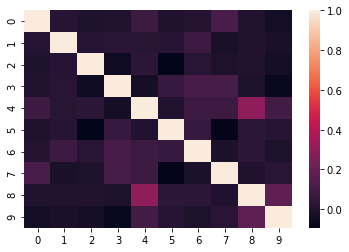

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [20]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

# Drill 1 - Test Set
## Apply LSA model to test set. Does it identify similar sentences for the components?

In [24]:
# convert to compressed sparse row matrix; reshape vectorizer to readable output
X_test_tfidf_csr = X_test_tfidf.tocsr()

#number of paragraphs
n = X_test_tfidf_csr.shape[0]

#list of dictionary by paragraphs
tfidf_bypara_test = [{} for _ in range(0,n)]

#list of features
terms = vectorizer.get_feature_names()

#for each paragraph list feature word and tf idf score
for i, j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara_test[i][terms[j]] = X_test_tfidf_csr[i,j]
    
print('Original sentence:', X_test[5])
print('Tf_idf vector:', tfidf_bypara_test[5])

Original sentence: " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
Tf_idf vector: {'resolving': 0.3424390305045805, 'unexceptionable': 0.3196409792117937, 'assure': 0.267729777836069, 'friends': 0.2515333740641343, 'quite': 0.1916471918420347, 'replied': 0.20315405638674577, 'watch': 0.62300800500314, 'elton': 0.16874782424809767, 'pass': 0.28445227585106625, 'really': 0.21963852817625326, 'mrs': 0.14780961753993585}


In [25]:
# SVD has already been generated and fitted, to reduce feature space to 130
X_test_lsa = lsa.transform(X_test_tfidf)

paras_by_component = pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
" Oh !       0.999288
" Oh !       0.999288
" Oh !       0.999288
" Oh !       0.999288
" Oh !       0.999288
" Oh !"      0.999288
" Oh !       0.999288
" Oh no !    0.999288
" Oh !       0.999288
" Oh !       0.999288
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.675469
Frank turned instantly to Emma , to claim her former promise ; and boasted himself an engaged man , which his father looked his most perfect approbation of  and it then appeared that Mrs . Weston was wanting _him_ to dance with Mrs . Elton himself , and that their business was to hel

# Drill 2 - Tweaking tf-idf
## Change some decision points and see how it affects results of the LSA

In [32]:
# don't drop words that occurs more than half
vectorizer = TfidfVectorizer(max_df=1.0,
                            min_df=2,
                            stop_words='english',
                            lowercase=True,
                            norm=u'l2'
                           )

def runLSA(vectorizer):
    #Applying the vectorizer
    emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
    print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

    #splitting into training and test sets
    X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


    #Reshapes the vectorizer output into something people can read
    X_train_tfidf_csr = X_train_tfidf.tocsr()

    #number of paragraphs
    n = X_train_tfidf_csr.shape[0]
    #A list of dictionaries, one per paragraph
    tfidf_bypara = [{} for _ in range(0,n)]
    #List of features
    terms = vectorizer.get_feature_names()
    #for each paragraph, lists the feature words and their tf-idf scores
    for i, j in zip(*X_train_tfidf_csr.nonzero()):
        tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]
    
    # Run SVD on the training data, then project the training data.
    X_train_lsa = lsa.fit_transform(X_train_tfidf)

    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    print("Percent variance captured by all components:",total_variance*100)

    #Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
    paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
    for i in range(5):
        print('Component {}:'.format(i))
        print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

In [33]:
runLSA(vectorizer)

Number of features: 1948
Percent variance captured by all components: 45.179529194075236
Component 0:
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !"    0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !"    0.999289
" Oh !     0.999289
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.634406
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.582981
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                         0.568102
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma

In [34]:
# no stop words
vectorizer = TfidfVectorizer(max_df=0.5,
                            min_df=2,
                            #stop_words='english',
                            lowercase=True,
                            norm=u'l2'
                           )

runLSA(vectorizer)

Number of features: 2178
Percent variance captured by all components: 50.83299601218349
Component 0:
Mrs . Weston was acting no part , feigning no feelings in all that she said to him in favour of the event . She had been extremely surprized , never more so , than when Emma first opened the affair to her ; but she saw in it only increase of happiness to all , and had no scruple in urging him to the utmost . She had such a regard for Mr . Knightley , as to think he deserved even her dearest Emma ; and it was in every respect so proper , suitable , and unexceptionable a connexion , and in one respect , one point of the highest importance , so peculiarly eligible , so singularly fortunate , that now it seemed as if Emma could not safely have attached herself to any other creature , and that she had herself been the stupidest of beings in not having thought of it , and wished it long ago . How very few of those men in a rank of life to address Emma would have renounced their own home for H

In [35]:
# no lower casing words
vectorizer = TfidfVectorizer(max_df=0.5,
                            min_df=2,
                            stop_words='english',
                            #lowercase=True,
                            norm=u'l2'
                           )

runLSA(vectorizer)

Number of features: 1948
Percent variance captured by all components: 45.168961179134385
Component 0:
" Oh !    0.999288
" Oh !    0.999288
Oh !      0.999288
" Oh !    0.999288
" Oh !    0.999288
" Oh !    0.999288
" Oh !    0.999288
" Oh !    0.999288
" Oh !    0.999288
" Oh !    0.999288
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.634230
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.569304
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                         0.560240
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harri

In [36]:
# no normalization; penalty
vectorizer = TfidfVectorizer(max_df=0.5,
                            min_df=2,
                            stop_words='english',
                            lowercase=True,
                            #norm=u'l2'
                           )

runLSA(vectorizer)

Number of features: 1948
Percent variance captured by all components: 45.193486196017076
Component 0:
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !"    0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.633084
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.577566
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.560786
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a 

In [37]:
# use words that show up at least once, not twice
vectorizer = TfidfVectorizer(max_df=0.5,
                            min_df=1,
                            stop_words='english',
                            lowercase=True,
                            norm=u'l2'
                           )

runLSA(vectorizer)

Number of features: 3851
Percent variance captured by all components: 41.22296388685908
Component 0:
" Oh !     0.999339
" Oh !     0.999339
" Oh !     0.999339
" Oh !     0.999339
" Oh !     0.999339
" Oh !     0.999339
" Oh !     0.999339
" Oh !"    0.999339
" Oh !     0.999339
" Oh !     0.999339
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.618327
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                         0.575808
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.560439
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                